✅ Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]



🚀 Running FIFO baseline...
[FIFO] Task 1: before=0.447 after=0.999 | mem_size=300
[FIFO] Task 2: before=0.508 after=0.487 | mem_size=300
[FIFO] Task 3: before=0.335 after=0.310 | mem_size=300
[FIFO] Task 4: before=0.233 after=0.246 | mem_size=300
[FIFO] Task 5: before=0.197 after=0.190 | mem_size=300

📌 FIFO Final accuracy: 0.190


🚀 Running MemorySafe-Taste...
[MemorySafe-Taste] Task 1: before=0.447 after=1.000 | mem={'size': 300.0, 'protect_pool': 210.0, 'repr_pool': 90.0}
[MemorySafe-Taste] Task 2: before=0.509 after=0.986 | mem={'size': 300.0, 'protect_pool': 210.0, 'repr_pool': 90.0}
[MemorySafe-Taste] Task 3: before=0.679 after=0.875 | mem={'size': 300.0, 'protect_pool': 210.0, 'repr_pool': 90.0}
[MemorySafe-Taste] Task 4: before=0.658 after=0.838 | mem={'size': 300.0, 'protect_pool': 210.0, 'repr_pool': 90.0}
[MemorySafe-Taste] Task 5: before=0.671 after=0.695 | mem={'size': 300.0, 'protect_pool': 210.0, 'repr_pool': 90.0}

📌 MemorySafe-Taste Final accuracy: 0.695



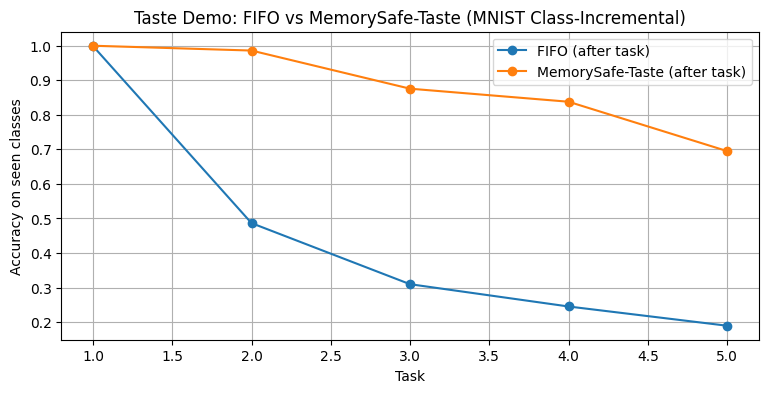

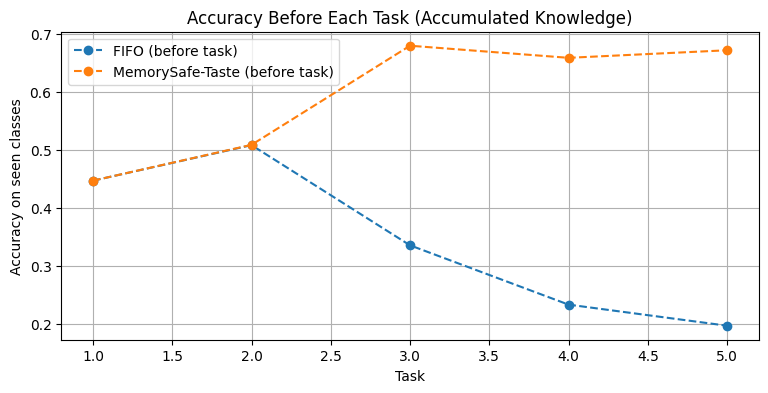


📌 Final Summary
FIFO final accuracy:           0.190
MemorySafe-Taste final accuracy:0.695
Relative improvement (final):  3.66x

✅ Done. This demo compares a FIFO baseline against a non-proprietary MemorySafe-style governance buffer.


In [1]:
# Taste Demo: MemorySafe-Taste vs FIFO (Colab-ready, Non-IP)
# ----------------------------------------------------------

# This demo DOES NOT include proprietary MemorySafe policy/MVI.


import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# -----------------------------
# Config
# -----------------------------
SEED = 42
TASKS = 5                 # MNIST split into 5 tasks, 2 classes each
EPOCHS_PER_TASK = 2       # CPU stability; set to 1 for fastest run
BATCH_SIZE = 128
LR = 1e-3
MEM_CAPACITY = 300
REPLAY_BATCH = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Device: {DEVICE}")

# -----------------------------
# Dataset
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

TASK_SPLITS = [list(range(i*2, i*2+2)) for i in range(TASKS)]  # (0,1),(2,3),(4,5),(6,7),(8,9)

def indices_for_classes(ds, classes: List[int]) -> List[int]:
    idx = []
    for i in range(len(ds)):
        _, y = ds[i]
        if int(y) in classes:
            idx.append(i)
    return idx

# -----------------------------
# Model
# -----------------------------
class TinyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)        # 28 -> 14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)        # 14 -> 7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------------------
# Memory items
# -----------------------------
@dataclass
class MemoryItem:
    x: torch.Tensor
    y: int
    protect_score: float
    seen_step: int

# -----------------------------
# FIFO Buffer
# -----------------------------
class FIFOBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.items: List[MemoryItem] = []
        self.step = 0

    def add_batch(self, x: torch.Tensor, y: torch.Tensor):
        x = x.detach().cpu()
        y = y.detach().cpu()
        for i in range(x.size(0)):
            self.items.append(MemoryItem(x=x[i], y=int(y[i]), protect_score=0.0, seen_step=self.step))
            self.step += 1
        if len(self.items) > self.capacity:
            self.items = self.items[-self.capacity:]  # keep newest

    def sample(self, n: int) -> Optional[Tuple[torch.Tensor, torch.Tensor]]:
        if not self.items:
            return None
        n = min(n, len(self.items))
        idx = np.random.choice(len(self.items), size=n, replace=False)
        xs = torch.stack([self.items[i].x for i in idx]).to(DEVICE)
        ys = torch.tensor([self.items[i].y for i in idx], device=DEVICE)
        return xs, ys

    def stats(self) -> Dict[str, float]:
        return {"size": float(len(self.items))}

# -----------------------------
# MemorySafe-Taste Buffer (non-IP)
# -----------------------------
class TasteMemorySafeBuffer:
    """
    Non-IP demo buffer with guardrails:
    1) per-class quota to avoid collapse into only hard samples
    2) mix of protected (hard/uncertain) + representative (diverse) memories

    This makes the demo stable and interpretable while keeping proprietary logic hidden.
    """
    def __init__(self, capacity: int, num_classes: int = 10, protect_frac: float = 0.7):
        self.capacity = capacity
        self.num_classes = num_classes
        self.protect_frac = protect_frac
        self.step = 0

        self.protect_cap = int(capacity * protect_frac)
        self.repr_cap = capacity - self.protect_cap

        self.protect_items: List[MemoryItem] = []
        self.repr_items: List[MemoryItem] = []

        self.per_class_quota_protect = max(1, self.protect_cap // num_classes)
        self.per_class_quota_repr = max(1, self.repr_cap // num_classes)

    @torch.no_grad()
    def compute_score(self, logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        probs = F.softmax(logits, dim=1)
        p_true = probs.gather(1, y.view(-1, 1)).squeeze(1)
        loss_proxy = (-torch.log(p_true + 1e-8))

        top2 = torch.topk(probs, k=2, dim=1).values
        margin = (top2[:, 0] - top2[:, 1]).clamp(min=0.0)

        loss_n = (loss_proxy / (loss_proxy.max() + 1e-8)).clamp(0, 1)
        margin_n = (1.0 - (margin / (margin.max() + 1e-8))).clamp(0, 1)

        score = 0.65 * loss_n + 0.35 * margin_n
        return score.clamp(0, 1)

    def _quota_topk(self, items: List[MemoryItem], per_class_quota: int) -> List[MemoryItem]:
        by_class = defaultdict(list)
        for it in items:
            by_class[it.y].append(it)
        kept: List[MemoryItem] = []
        for c, lst in by_class.items():
            lst.sort(key=lambda z: z.protect_score, reverse=True)
            kept.extend(lst[:per_class_quota])
        return kept

    def add_batch(self, x: torch.Tensor, y: torch.Tensor, score: torch.Tensor):
        x = x.detach().cpu()
        y = y.detach().cpu()
        score = score.detach().cpu()

        for i in range(x.size(0)):
            it = MemoryItem(x=x[i], y=int(y[i]), protect_score=float(score[i].item()), seen_step=self.step)
            self.step += 1
            if it.protect_score >= 0.6:
                self.protect_items.append(it)
            else:
                self.repr_items.append(it)

        # Protected: keep top by score + per-class quota
        if len(self.protect_items) > self.protect_cap:
            self.protect_items.sort(key=lambda d: d.protect_score, reverse=True)
            cand = self.protect_items[: self.protect_cap * 2]
            kept = self._quota_topk(cand, self.per_class_quota_protect)
            if len(kept) < self.protect_cap:
                kept_ids = set(id(k) for k in kept)
                rem = [t for t in cand if id(t) not in kept_ids]
                rem.sort(key=lambda d: d.protect_score, reverse=True)
                kept.extend(rem[: self.protect_cap - len(kept)])
            self.protect_items = kept[: self.protect_cap]

        # Representative: diversity (older + random) + quota
        if len(self.repr_items) > self.repr_cap:
            self.repr_items.sort(key=lambda d: d.seen_step)
            keep_old = self.repr_items[: max(1, self.repr_cap // 2)]
            remaining = self.repr_items[len(keep_old):]

            keep_rand: List[MemoryItem] = []
            if remaining:
                k = min(len(remaining), self.repr_cap - len(keep_old))
                idx = np.random.choice(len(remaining), size=k, replace=False)
                keep_rand = [remaining[j] for j in idx]

            mixed = keep_old + keep_rand
            kept = self._quota_topk(mixed, self.per_class_quota_repr)
            if len(kept) < self.repr_cap:
                kept_ids = set(id(k) for k in kept)
                rem2 = [t for t in mixed if id(t) not in kept_ids]
                rem2.sort(key=lambda d: d.seen_step)
                kept.extend(rem2[: self.repr_cap - len(kept)])
            self.repr_items = kept[: self.repr_cap]

    def sample(self, n: int) -> Optional[Tuple[torch.Tensor, torch.Tensor]]:
        all_items = self.protect_items + self.repr_items
        if not all_items:
            return None
        n = min(n, len(all_items))

        n_protect = min(len(self.protect_items), max(1, int(n * 0.7))) if self.protect_items else 0
        n_repr = min(len(self.repr_items), n - n_protect) if self.repr_items else 0

        xs, ys = [], []
        if n_protect > 0:
            idx_p = np.random.choice(len(self.protect_items), size=n_protect, replace=False)
            for i in idx_p:
                xs.append(self.protect_items[i].x)
                ys.append(self.protect_items[i].y)

        if n_repr > 0:
            idx_r = np.random.choice(len(self.repr_items), size=n_repr, replace=False)
            for i in idx_r:
                xs.append(self.repr_items[i].x)
                ys.append(self.repr_items[i].y)

        xs_t = torch.stack(xs).to(DEVICE)
        ys_t = torch.tensor(ys, device=DEVICE)
        return xs_t, ys_t

    def stats(self) -> Dict[str, float]:
        all_items = self.protect_items + self.repr_items
        if not all_items:
            return {"size": 0.0, "protect_pool": 0.0, "repr_pool": 0.0}
        return {"size": float(len(all_items)), "protect_pool": float(len(self.protect_items)), "repr_pool": float(len(self.repr_items))}

# -----------------------------
# Evaluation
# -----------------------------
@torch.no_grad()
def evaluate(model: nn.Module, seen_classes: List[int]) -> float:
    model.eval()
    idx = indices_for_classes(test_ds, seen_classes)
    loader = DataLoader(Subset(test_ds, idx), batch_size=256, shuffle=False)
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / max(total, 1)

# -----------------------------
# Run one policy
# -----------------------------
def run_policy(policy_name: str) -> Dict[str, List[float]]:
    # ensure identical init across policies
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

    model = TinyCNN(num_classes=10).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    if policy_name == "FIFO":
        buffer = FIFOBuffer(capacity=MEM_CAPACITY)
    elif policy_name == "MemorySafe-Taste":
        buffer = TasteMemorySafeBuffer(capacity=MEM_CAPACITY, num_classes=10, protect_frac=0.7)
    else:
        raise ValueError("Unknown policy")

    history = {"task": [], "acc_before": [], "acc_after": []}
    seen: List[int] = []

    for task_id, classes in enumerate(TASK_SPLITS, start=1):
        seen += classes
        train_idx = indices_for_classes(train_ds, classes)
        train_loader = DataLoader(Subset(train_ds, train_idx), batch_size=BATCH_SIZE, shuffle=True)

        acc_before = evaluate(model, seen)

        model.train()
        for _ in range(EPOCHS_PER_TASK):
            for x, y in train_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                replay = buffer.sample(REPLAY_BATCH)
                if replay is not None:
                    rx, ry = replay
                    x_full = torch.cat([x, rx], dim=0)
                    y_full = torch.cat([y, ry], dim=0)
                else:
                    x_full, y_full = x, y

                opt.zero_grad()
                logits = model(x_full)
                loss = F.cross_entropy(logits, y_full)
                loss.backward()
                opt.step()

                # update buffer using only current batch
                with torch.no_grad():
                    logits_cur = model(x)
                if policy_name == "FIFO":
                    buffer.add_batch(x, y)
                else:
                    score = buffer.compute_score(logits_cur, y)
                    buffer.add_batch(x, y, score)

        acc_after = evaluate(model, seen)

        history["task"].append(task_id)
        history["acc_before"].append(acc_before)
        history["acc_after"].append(acc_after)

        # per-task log
        if policy_name == "MemorySafe-Taste":
            st = buffer.stats()
            print(f"[{policy_name}] Task {task_id}: before={acc_before:.3f} after={acc_after:.3f} | mem={st}")
        else:
            print(f"[{policy_name}] Task {task_id}: before={acc_before:.3f} after={acc_after:.3f} | mem_size={buffer.stats()['size']:.0f}")

    print(f"\n📌 {policy_name} Final accuracy: {history['acc_after'][-1]:.3f}\n")
    return history

# -----------------------------
# Run both policies
# -----------------------------
print("\n🚀 Running FIFO baseline...")
fifo_hist = run_policy("FIFO")

print("\n🚀 Running MemorySafe-Taste...")
ms_hist = run_policy("MemorySafe-Taste")

# -----------------------------
# Plot
# -----------------------------
try:
    import matplotlib.pyplot as plt

    tasks = fifo_hist["task"]

    plt.figure(figsize=(9, 4))
    plt.plot(tasks, fifo_hist["acc_after"], marker="o", label="FIFO (after task)")
    plt.plot(tasks, ms_hist["acc_after"], marker="o", label="MemorySafe-Taste (after task)")
    plt.xlabel("Task")
    plt.ylabel("Accuracy on seen classes")
    plt.title("Taste Demo: FIFO vs MemorySafe-Taste (MNIST Class-Incremental)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(tasks, fifo_hist["acc_before"], marker="o", linestyle="--", label="FIFO (before task)")
    plt.plot(tasks, ms_hist["acc_before"], marker="o", linestyle="--", label="MemorySafe-Taste (before task)")
    plt.xlabel("Task")
    plt.ylabel("Accuracy on seen classes")
    plt.title("Accuracy Before Each Task (Accumulated Knowledge)")
    plt.grid(True)
    plt.legend()
    plt.show()

except Exception as e:
    print("Plot skipped:", e)

# -----------------------------
# Final summary
# -----------------------------
fifo_final = fifo_hist["acc_after"][-1]
ms_final = ms_hist["acc_after"][-1]
ratio = ms_final / max(fifo_final, 1e-8)

print("\n📌 Final Summary")
print(f"FIFO final accuracy:           {fifo_final:.3f}")
print(f"MemorySafe-Taste final accuracy:{ms_final:.3f}")
print(f"Relative improvement (final):  {ratio:.2f}x")
print("\n✅ Done. This demo compares a FIFO baseline against a non-proprietary MemorySafe-style governance buffer.")
